In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
import math
import pandas as pd
import numpy as np
from numpy import *
import scipy.stats as stats
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
Nodes = 0

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
class TreeNode:
    Nodes = 0
    def __init__(self, attribute):
        self.attribute = attribute
        self.children = {}

    def display(self, level = 0):
        if self.children == {}: 
            print(": ", self.attribute, end="")
        else:
            for value in self.children.keys():
                prefix = "\n" + " " * level * 4
                print(prefix, self.attribute, "=", value, end="")
                self.children[value].display(level + 1)
     
    def predicts(self, root, catAtt):
        if self.children == {}: 
            return self.attribute
        if self.attribute in catAtt:
            value = root[self.attribute]
            if value in self.children:
                subtree = self.children[value]
                return subtree.predicts(root, catAtt)
        else:
            val = 0
            for val1 in self.children.keys():
                val = val1
            feature_name, comparison_operator, value, pos = val.split(" ")
            if root[feature_name] <= float(value):
                Question = "{} <= {} left".format(feature_name, value)
                subtree = self.children[Question]
            else:
                Question = "{} <= {} right".format(feature_name, value)
                subtree = self.children[Question] 
            return subtree.predicts(root, catAtt)

In [4]:
def CountTotalLabels(labelData):
    positive, negative = 0, 0
    for label in labelData:
        if label == 0:
            positive += 1
        else:
            negative += 1
    return positive, negative

In [5]:
def getEntropy(examples, target):
    positive, negative = CountTotalLabels(examples[target])
    logv = log(2)
    logv = logv * (positive + negative)
    Entropy = 0.0
    if not positive == 0:
        Entropy = positive * (-log(positive/(positive + negative)))/logv
    if not negative == 0:
        Entropy = Entropy + negative * (-log(negative/(positive + negative)))/logv
    return Entropy

In [6]:
def get_potential_splits(data):
    unique_values = np.unique(data)
    potential_splits = []
    unique_values.sort()
    for index in range(len(unique_values)):
        if index != 0:
            current_value = unique_values[index]
            previous_value = unique_values[index - 1]
            potential_split = (current_value + previous_value) / 2
            potential_splits.append(potential_split)
    
    return potential_splits

In [7]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [8]:
def getBestAttribute(examples, target, attributes, trainData):
    baseEntropy = getEntropy(examples, target)
    TotalLength = len(examples)
    informationGain = []
    
    for attribute in attributes:
        unique_values = np.unique(trainData[attribute])
        if len(unique_values) < 3 or (len(unique_values) >= 3 and isinstance(unique_values[0], str)):
            groupedData = examples.groupby(attribute)
            totalEntropy = 0
            for key,exampleSubset in groupedData:
                del exampleSubset[attribute]
                entropyOfSubset = getEntropy(exampleSubset,target)
                totalEntropy += (len(exampleSubset)/ TotalLength)*entropyOfSubset
            informationGain.append([attribute, baseEntropy-totalEntropy, key])
        else:
            potential_splits = get_potential_splits(examples[attribute])
            totalEntropy, val, overall_entropy = 0, 0, 999
            for value in potential_splits:
                data_below, data_above = split_data(examples, split_column=attribute, split_value=value)
                n = len(data_below) + len(data_above)
                totalEntropy =  ((len(data_below) / n) * getEntropy(data_below, target) 
                                  + (len(data_above) / n) * getEntropy(data_above, target))
                if totalEntropy <= overall_entropy:
                    overall_entropy = totalEntropy
                    val = value
            informationGain.append([attribute,baseEntropy-overall_entropy,val])

    bestAttribute = max(informationGain, key=lambda x: x[1])
    return bestAttribute[0], bestAttribute[2]

In [9]:
def classify_data(examples, target, attributes, max_level):
    if len(attributes) == 0 or max_level == 1:
        item_counts = examples[target].value_counts()
        max_item = item_counts.idxmax()
        return max_item
    else:
        return False

In [10]:
def data_purity(examples, target):
    uniques = examples.apply(lambda x: x.nunique()).loc[target]
    if uniques == 1:
        return True
    else:
        return False

In [11]:
def decisionTree(examples, target, attributes1, trainData, max_level = 15):
    global Nodes
    Nodes += 1
    attributes = attributes1[:] # Make it as Local
    if data_purity(examples, target):
        return TreeNode(examples[target].iloc[0])

    max_item = classify_data(examples, target, attributes, max_level)
    if len(attributes) == 0 or max_level == 1:
        return TreeNode(max_item)
    
    
    bestAttribute, bestValue = getBestAttribute(examples, target, attributes, trainData)
    attributeRoot = TreeNode(bestAttribute)
    
    unique_values = np.unique(trainData[bestAttribute])
    if len(unique_values) < 3 or (len(unique_values) >= 3 and isinstance(unique_values[0], str)):
        attributes.remove(bestAttribute)
        groupedData = examples.groupby(bestAttribute)
        for key,exampleSubset in groupedData:
                if len(exampleSubset) == 0:
                    item_counts = exampleSubset[target].value_counts()
                    max_item = item_counts.idxmax()
                    attributeRoot.children[key] = TreeNode(max_item)
                else:
                    attributeRoot.children[key] = decisionTree(exampleSubset.drop([bestAttribute],axis=1), 
                                                               target, attributes, trainData, max_level - 1)
    else:
        data_below, data_above = split_data(examples, split_column=bestAttribute, split_value=bestValue)

        if len(data_below) == 0 or len(data_above) == 0 or max_level == 1:
            attributes.remove(bestAttribute)
            item_counts = examples[target].value_counts()
            max_item = item_counts.idxmax()
            return TreeNode(max_item) 
        
        key = "{} <= {} left".format(bestAttribute, bestValue)
    
        attributeRoot.children[key] = decisionTree(data_below, target, attributes, trainData, max_level - 1)
        key = "{} <= {} right".format(bestAttribute, bestValue)

        attributeRoot.children[key] = decisionTree(data_above, target, attributes, trainData, max_level - 1)

    return attributeRoot

In [12]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [13]:
def EvaluatingTree(tree, test, target, catAtt):
    correct = 0
    for i in range(0, len(test)):
        if str(tree.predicts(test.loc[i], catAtt)) == str(test.loc[i,target]):
            correct += 1
    return correct/len(test)

In [14]:
if __name__ == "__main__":
    data = loadmat("/content/gdrive/My Drive/Prakrati/dataset/dataset_2.mat")
    samples, label = np.array(data['samples']), np.array(data['labels'])
    label = pd.DataFrame((label))
    label = label.T
    
    df = pd.DataFrame(list(samples), columns=['lat', 'long'])
    df['label'] = label
    target = "label"

    train, test = train_test_split(df, test_size = 0.2)
    test = test.reset_index()
    train = train.reset_index()
    
    attributes = train.columns.tolist()
    attributes.remove(target)
    
    catAtt = []
    trainAcc = []
    testAcc = []
    TotalNodes = []
    for max_level in range(3,15):
        global Nodes
        Nodes = 0
        tree = decisionTree(train, target, attributes, train, max_level)
        TotalNodes.append(Nodes)
        trainAcc.append(1-EvaluatingTree(tree, train, target, catAtt))
        testAcc.append(1-EvaluatingTree(tree, test, target, catAtt))

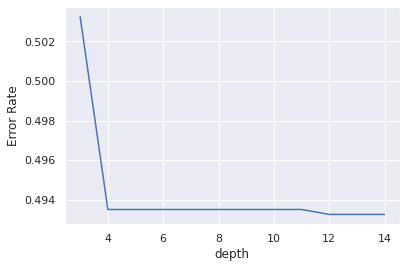

In [16]:
depth = np.arange(3, 15, 1)
plt.plot(depth, testAcc)
plt.xlabel('depth')
plt.ylabel('Error Rate')
plt.show()

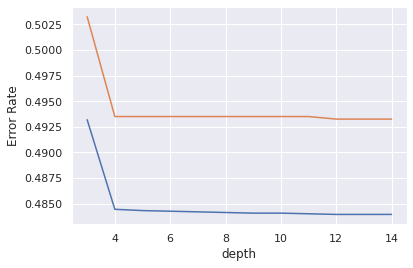

In [15]:
depth = np.arange(3, 15, 1)
plt.plot(depth, trainAcc)
plt.plot(depth, testAcc)
plt.xlabel('depth')
plt.ylabel('Error Rate')
plt.show()